# SETUP

In [345]:
# IMPORT MODULES

import numpy as np
from numpy import ma
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

import os

In [346]:
df = pd.read_csv('creditcard.csv')
print(df.shape)
print(df.columns)
df.head()

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# DATA PREPARATION

In [347]:
data = df.drop(["Time"], axis = 1)
normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [348]:
#  SCALER / Normalization

data = df.drop(["Time"], axis = 1)
scl = StandardScaler()
all_cols = list(data)[:] 
pca_columns = list(data)[:-1] # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fraud_data ", fraud_data.shape)
print("Percent fraud ", round(100*492/284807, 4),"%")

data  (284807, 30)
normal_data  (284315, 30)
fraud_data  (492, 30)
Percent fraud  0.1727 %


In [349]:
# CREATE the TRAIN and TEST sets
# Fraud data is ONLY in TEST - not in TRAIN

normal_pca_data = normal_data[pca_columns]
fraud_pca_data = fraud_data[pca_columns]

num_test = 75000
shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
X_train = shuffled_data

# X_valid = np.concatenate([shuffled_data[-2*num_test:-num_test], fraud_pca_data[:246]])
# y_valid = np.concatenate([np.zeros(num_test), np.ones(246)])

X_test = np.concatenate([normal_pca_data.sample(frac=1, random_state=1960)[-num_test:], fraud_pca_data[:129]])
# X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:129]])
# y_test = np.concatenate([np.zeros(num_test), np.ones(492)])
y_test = np.concatenate([np.zeros(num_test), np.ones(129)])

print("normal_pca_data ", normal_pca_data.shape)
print("fraud_pca_data", fraud_pca_data.shape)
print("Fraud data only in Test with NONE in the training")
print("X_train ", X_train.shape)
# print("X_valid ", X_valid.shape)
# print("y_valid ", y_valid.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)
np.unique(y_test, return_counts=True)

normal_pca_data  (284315, 29)
fraud_pca_data (492, 29)
Fraud data only in Test with NONE in the training
X_train  (209315, 29)
X_test  (75129, 29)
y_test  (75129,)


(array([0., 1.]), array([75000,   129]))

# GAUSSIAN MODEL

In [350]:
# Calculate the  prob on train vs test vs fraud data only (no normals at all)

# 1 - calculate p the gaussian matrix - like fit/train the model
p = multivariate_normal(mean=np.mean(X_train,axis=0), cov=np.cov(X_train.T))

x = p.pdf(X_train)
print("max prob of x on X_train", max(x))
print("mean prob of x on X_train", np.mean(x))

print('-' * 60)
MyTrain = np.mean(x)

x = p.pdf(X_test)
print("max prob of x on X_test", max(x))
print("mean prob of x on X_test", np.mean(x))

print('-' * 60)
MyTest = np.mean(x)

x = p.pdf(fraud_pca_data)
print("max prob of x on fraud_pca_data", max(x))
print("mean prob of x on fraud_pca_data", np.mean(x))

print('-' * 60)
MyFraud = np.mean(x)

print('Difference between mean prob of Train vs Fraud ', MyTrain - MyFraud)

max prob of x on X_train 4.196964400038096e-12
mean prob of x on X_train 1.438085699286696e-13
------------------------------------------------------------
max prob of x on X_test 3.555178235435575e-12
mean prob of x on X_test 1.4381800616719283e-13
------------------------------------------------------------
max prob of x on fraud_pca_data 2.854084326324794e-13
mean prob of x on fraud_pca_data 2.5480781953773987e-15
------------------------------------------------------------
Difference between mean prob of Train vs Fraud  1.412604917332922e-13


In [351]:
# Find best epsilon re F1 score

# 2 - calculate the score (x) for each observation on the mixture gaussian matrix
x = p.pdf(X_test)

# 3 - find the best threshold (eps) by using F1 as dependant variable
EpsF1 = []

epsilons = [1e-10, 1e-20, 1e-30, 1e-40, 1e-50, 1e-60, 1e-70, 1e-80, 1e-90, 1e-100, 1e-110, 1e-120,
           1e-130, 1e-140, 1e-150, 1e-160, 1e-170, 1e-180, 1e-190, 1e-200, 1e-210, 1e-220, 1e-230, 1e-240]

for e in range(len(epsilons)):
    eps = epsilons[e]
    pred = (x <= eps)
    f = f1_score(y_test, pred, average='binary')
    #print("F1 score on test", round(f,4), " with epsilon ", eps)
    EpsF1.append([eps, round(f,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['epsilon', 'F1'])
EpsF1df.head()
print(x)

[4.82345950e-16 4.80823955e-16 1.14124229e-12 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [352]:
# Best Epsilon ... Max F1 on test

EpsF1df.loc[EpsF1df['F1'].idxmax()]

epsilon    1.000000e-210
F1          5.977000e-01
Name: 20, dtype: float64

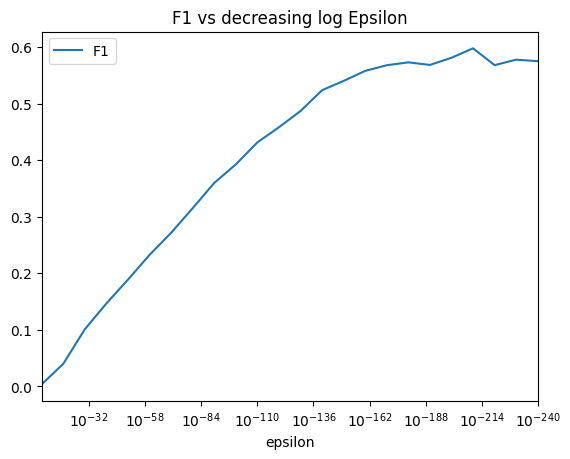

In [353]:
EpsF1df.plot.line("epsilon","F1")
plt.xscale('log')
plt.xlim(1e-10, 1e-240)
plt.title("F1 vs decreasing log Epsilon")
plt.show()

In [354]:
# CONFUSION MATRIX and F1 SCORE on Test w best epsilon

eps = EpsF1df.loc[EpsF1df['F1'].idxmax()]['epsilon']

print("epsilon ", eps)
print("_"*50)
pred = (x<=eps)
CM = confusion_matrix(y_test,pred)
tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()

print(CM)
print("_"*50)
print("TP ", tp)
print("FP ", fp)
print("TN ", tn)
print("FN ", fn)

epsilon  1e-210
__________________________________________________
[[74885   115]
 [   25   104]]
__________________________________________________
TP  104
FP  115
TN  74885
FN  25


In [355]:
# F1 Score
#print("F1 score", round(f1_score(y_valid,pred, average='binary'), 4))
precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test,pred, average='binary')
print("precision ", round((precision), 3))
print("recall ", round((recall), 3))
print("F1 score on Test", round((fbeta_score), 3))

precision  0.475
recall  0.806
F1 score on Test 0.598


In [356]:
index = where(x <= eps)
values = x[index]
values

array([0.00000000e+000, 4.17872366e-308, 0.00000000e+000, 0.00000000e+000,
       3.93260259e-268, 0.00000000e+000, 3.01235493e-214, 1.06706833e-258,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 9.15281184e-265, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 4.70715275e-212, 0.00000000e+000, 0.00000000e+000,
       2.00993795e-229, 0.00000000e+000, 7.82288832e-296, 1.39504832e-256,
       0.00000000e+000, 0.00000000e+000, 5.15277126e-300, 0.00000000e+000,
       3.94693631e-294, 3.41506034e-262, 2.07509736e-227, 0.00000000e+000,
       2.79211412e-309, 1.13718094e-293, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.06911701e-259,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       1.59430280e-236, 0.00000000e+000, 0.00000000e+000, 3.03887618e-214,
       6.10714671e-292, 7.49727331e-216, 4.34059852e-287, 0.00000000e+000,
       1.23959981e-228, 0